## Stock market prediction

In [37]:
import pandas as pd
import pandas_datareader as web
import talib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [38]:
# import SPY 10 years of data to the most recent date in 2021. 
# SPY is designed to track the S&P 500 stock market index. This fund is the largest ETF in the world. 
df = web.DataReader('SPY', data_source='yahoo', start='2010-01-01', end='2021-02-19')

## Exporatory Data Analysis

In [39]:
df.tail() # examine the stock data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-12,392.899994,389.769989,389.850006,392.640015,50505700.0,392.640015
2021-02-16,394.170013,391.529999,393.959991,392.299988,50700800.0,392.299988
2021-02-17,392.660004,389.329987,390.420013,392.390015,52290600.0,392.390015
2021-02-18,391.519989,387.739990,389.589996,390.720001,59552200.0,390.720001
2021-02-19,392.380005,389.549988,392.070007,390.029999,83142800.0,390.029999


In [40]:
df.shape # get the number of rows and columns

(2802, 6)

In [41]:
df.describe() # generate descriptive statistics

,High,Low,Open,Close,Volume,Adj Close
count,2802.000000,2802.000000,2802.000000,2802.000000,2.802000e+03,2802.000000
mean,210.783105,208.517659,209.704789,209.734333,1.237649e+08,192.583213
std,69.809154,69.075299,69.468840,69.454677,7.465493e+07,75.348641
min,103.419998,101.129997,103.110001,102.199997,2.027000e+07,82.872505
25%,142.442497,141.355003,141.982498,141.982498,7.239802e+07,120.491968
50%,206.800003,204.629997,205.614998,205.614998,1.038480e+08,184.856987
75%,268.587502,265.575005,267.577507,267.287506,1.530642e+08,254.170013
max,394.170013,391.529999,393.959991,392.640015,7.178287e+08,392.640015


[]

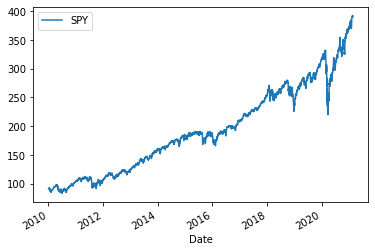

In [42]:
# plot the closing price
df['Adj Close'].plot(label='SPY', legend=True)
plt.plot()

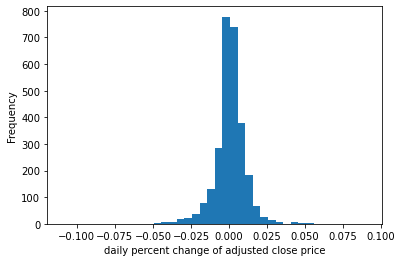

In [43]:
# histogram of the daily price change percent of the closing price
df['Adj Close'].pct_change().plot.hist(bins=40)
plt.xlabel('daily percent change of adjusted close price')
plt.show()

## Correlation coefficient
#### Exam how strong is the correlation of previous price changes vs future price changes. If it's highly correlated, then the stock price is trend following. Otherwise, the stock price is mean-reverting.

            Current Close Percent  Future Close Percent
Date                                                   
2010-01-04                    NaN                   NaN
2010-01-05                    NaN                   NaN
2010-01-06                    NaN                   NaN
2010-01-07                    NaN                   NaN
2010-01-08                    NaN                   NaN
...                           ...                   ...
2021-02-12               0.012716             -0.006647
2021-02-16               0.004584             -0.005786
2021-02-17               0.005484             -0.006014
2021-02-18               0.001641             -0.001766
2021-02-19              -0.001740              0.000000

[2802 rows x 2 columns]


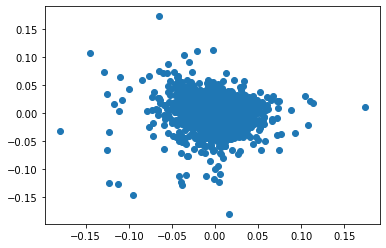

In [44]:
trading_period = 5 # define the trading period to calculate the correlation

df['Future Close'] = df['Adj Close'].shift(-5) # create a new future price of the next 5 trading days
df['Future Close Percent'] = df['Future Close'].pct_change(trading_period) # Future price change percentage
df['Current Close Percent'] = df['Adj Close'].pct_change(trading_period) # Current price change percentage

corr = df[['Current Close Percent', 'Future Close Percent']]
print(corr)

# plot the correlation
plt.scatter(df['Current Close Percent'], df['Future Close Percent'])

#### We can see the future price change is negatively correlated to the previous price change for a 5 days trading period. This tells us that a mean reversion traing would be a good trading strategy.

## Feature Engineering
#### We want to add more data to the machinee learning models to make better prediction. We will add the new features below:
#### 1. Adding a simple moving average (SMA) which is one of the most common indicators which is the average of data point.

<AxesSubplot:ylabel='Frequency'>

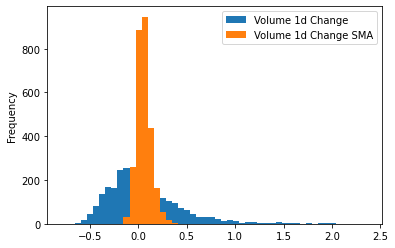

In [45]:
new_features = []

volume_features = ['Volume 1d Change', 'Volume 1d Change SMA']
new_features.extend(volume_features)

# new feature - volumne change percentage in 1 day
df['Volume 1d Change'] = df['Volume'].pct_change(1)

# new feature - 8 day moving average of the 1 day percent change in volume
df['Volume 1d Change SMA'] = talib.SMA(df['Volume 1d Change'].values, timeperiod=8)

df[volume_features].plot(kind='hist', sharex=False, bins=50)

#### 2. Adding a day of the week feature

In [46]:
days_of_week = pd.get_dummies(df.index.dayofweek,
                             prefix='Day of Week',
                             drop_first=True)

days_of_week.index = df.index
# join the data frame
df = pd.concat([df, days_of_week], axis=1)

# add days of week to the list of new features
new_features.extend(['Day of Week_' + str(n) for n in range(1, 5)] )
# drop missing value
df.dropna(inplace=True)

df.head()


,High,Low,Open,Close,Volume,Adj Close,Future Close,Future Close Percent,Current Close Percent,Volume 1d Change,Volume 1d Change SMA,Day of Week_1,Day of Week_2,Day of Week_3,Day of Week_4
Date,,,,,,,,,,,,,,,
2010-01-14,115.139999,114.419998,114.489998,114.930000,115718800.0,92.373383,87.776047,-0.049769,0.006480,-0.284901,0.019352,0,0,1,0
2010-01-15,114.839996,113.199997,114.730003,113.639999,212283100.0,91.336594,88.226112,-0.034055,-0.008117,0.834474,0.131401,0,0,0,1
2010-01-19,115.129997,113.589996,113.620003,115.059998,139172700.0,92.477890,87.856384,-0.049974,0.002876,-0.344400,0.083316,1,0,0,0
2010-01-20,114.449997,112.980003,114.279999,113.889999,216490200.0,91.537521,88.274338,-0.035649,0.002024,0.555551,0.136588,0,1,0,0
2010-01-21,114.269997,111.559998,113.919998,111.699997,344859600.0,89.777344,87.261650,-0.028021,-0.025475,0.592957,0.215178,0,0,1,0
